In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_haploblocks_parameters(lr_type, depth_hic, depth_lr, sampling_num):
    hap_path = '/DATA/users/m.magnitov/hap_phen/simulations/haplotypes'
    with open(f'{hap_path}/output_hic_{lr_type}/chr1_{depth_hic}x_hic_{depth_lr}x_{lr_type}_ds{sampling_num}.hap', 'r') as f:
        haplotypes_stats = f.readlines()
    haplotypes_stats = [x for x in haplotypes_stats if 'BLOCK' in x]

    snp_num, snp_phased_num, block_span = [], [], []
    for block in haplotypes_stats:
        snp_num.append(int(block.split('len:')[1].split('phased:')[0][1:-1]))
        snp_phased_num.append(int(block.split('phased:')[1].split('SPAN:')[0][1:-1]))
        block_span.append(int(block.split('SPAN:')[1].split('fragment')[0][1:-1]))

    haploblocks_data = pd.DataFrame([snp_phased_num, block_span]).transpose()
    haploblocks_data.columns = ['het_snp_phased', 'span']
    haploblocks_data = haploblocks_data.sort_values(['span'], ascending = 0)

    # size of chr1 in hg38 and number of heterozygous SNPs for chr1 in NA12878
    chrom_size = 248956422
    het_variants = 195087

    haploblocks_data['het_snp_phased_frac'] = [x/het_variants for x in haploblocks_data['het_snp_phased']]
    haploblocks_data['span_frac'] = [x/chrom_size for x in haploblocks_data['span']]

    # "most variants phased" block is defined by maximizing span and phased heterozygous SNPs
    haploblocks_data['mvp'] = haploblocks_data['span_frac']*haploblocks_data['het_snp_phased_frac']

    return(haploblocks_data.sort_values(['mvp'], ascending = False))

In [3]:
def get_error_rates(lr, depth_hic, depth_lr, ds_num):
    hap_path = '/DATA/users/m.magnitov/hap_phen/simulations/haplotypes'
    with open(f'{hap_path}/output_hic_{lr}/hap_stats_{depth_hic}x_hic_{depth_lr}x_{lr}_ds{ds_num}.txt', 'r') as f:
        haplotypes_comparison = f.read()
    switch_rate = float(haplotypes_comparison.split('switch rate:')[-1].split('\n')[0].lstrip())
    mismatch_rate = float(haplotypes_comparison.split('mismatch rate:')[-1].split('\n')[0].lstrip())
    return([switch_rate, mismatch_rate])

In [4]:
downsampling_reps = np.arange(1, 21, 1)
downsampling_depths = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 16, 20, 24, 32]

## 10X linked-reads simulations

In [6]:
haploblock_spans, phased_snps, switch_errors, mismatch_errors = [], [], [], []

for downsample_num in downsampling_reps:
    spans_tmp, snps_tmp, switches_tmp, mismatches_tmp = [], [], [], []
    for frac_lr in downsampling_depths:
        for frac_hic in downsampling_depths:
            
            # Extract information about MVP block and phased SNPs
            stats = get_haploblocks_parameters('10X', frac_hic, frac_lr, downsample_num)
            spans_tmp.append(stats['span_frac'].values[0])
            snps_tmp.append(stats['het_snp_phased_frac'].values[0])
            
            # Extract information about switch and mismatch errors
            errors = get_error_rates('10X', frac_hic, frac_lr, downsample_num)
            if errors[0] != 0 and errors[0] != 1:
                switches_tmp.append(errors[0])
            else:
                switches_tmp.append(np.nan)
            if errors[1] != 0 and errors[1] != 1:
                mismatches_tmp.append(errors[1])
            else:
                mismatches_tmp.append(np.nan)
                
    haploblock_spans.append(spans_tmp)
    phased_snps.append(snps_tmp)
    switch_errors.append(switches_tmp)
    mismatch_errors.append(mismatches_tmp)
    
haploblock_spans = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in haploblock_spans]
phased_snps = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in phased_snps]
switch_errors = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in switch_errors]
mismatch_errors = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in mismatch_errors]

In [20]:
np.save('simulations_haploblock_spans_10X_HiC.npy', haploblock_spans)
np.save('simulations_phased_snps_10X_HiC.npy', phased_snps)
np.save('simulations_switch_errors_10X_HiC.npy', switch_errors)
np.save('simulations_mismatch_errors_10X_HiC.npy', mismatch_errors)

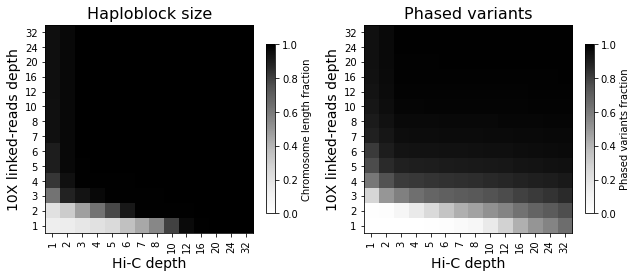

In [21]:
plt.figure(figsize = (9, 5))

plt.subplot(121)
plt.title('Haploblock size', fontsize = 16)
plt.imshow(np.average(haploblock_spans, axis = 0), vmin = 0, vmax = 1, cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('10X linked-reads depth', fontsize = 14)
plt.colorbar(shrink = 0.5, label = 'Chromosome length fraction')

plt.subplot(122)
plt.title('Phased variants', fontsize = 16)
plt.imshow(np.average(phased_snps, axis = 0), vmin = 0, vmax = 1, cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('10X linked-reads depth', fontsize = 14)
plt.colorbar(shrink = 0.5, label = 'Phased variants fraction')

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/simulations_10X_haploblock_variants.pdf', bbox_inches = 'tight')
plt.show()

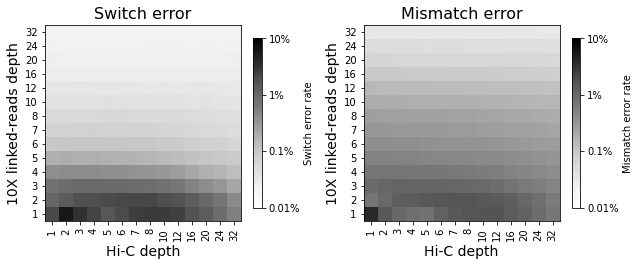

In [22]:
plt.figure(figsize = (9, 5))

plt.subplot(121)
plt.title('Switch error', fontsize = 16)
plt.imshow(np.log10(np.average(np.ma.masked_array(switch_errors, np.isnan(switch_errors)), axis = 0)).data, 
           vmax = np.log10(0.1), vmin = np.log10(0.0001), cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('10X linked-reads depth', fontsize = 14)
cbar = plt.colorbar(shrink = 0.5, ticks = np.log10([0.1, 0.01, 0.001, 0.0001]), label = 'Switch error rate')
cbar.ax.set_yticklabels(['10%', '1%', '0.1%', '0.01%'])

plt.subplot(122)
plt.title('Mismatch error', fontsize = 16)
plt.imshow(np.log10(np.average(np.ma.masked_array(mismatch_errors, np.isnan(mismatch_errors)), axis = 0)).data, 
           vmax = np.log10(0.1), vmin = np.log10(0.0001), cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('10X linked-reads depth', fontsize = 14)
cbar = plt.colorbar(shrink = 0.5, ticks = np.log10([0.1, 0.01, 0.001, 0.0001]), label = 'Mismatch error rate')
cbar.ax.set_yticklabels(['10%', '1%', '0.1%', '0.01%'])

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/simulations_10X_switch_mismatch.pdf', bbox_inches = 'tight')
plt.show()

## TELL-seq reads simulations

In [23]:
haploblock_spans, phased_snps, switch_errors, mismatch_errors = [], [], [], []

for downsample_num in downsampling_reps:
    spans_tmp, snps_tmp, switches_tmp, mismatches_tmp = [], [], [], []
    for frac_lr in downsampling_depths:
        for frac_hic in downsampling_depths:
            
            # Extract information about MVP block and phased SNPs
            stats = get_haploblocks_parameters('tellseq', frac_hic, frac_lr, downsample_num)
            spans_tmp.append(stats['span_frac'].values[0])
            snps_tmp.append(stats['het_snp_phased_frac'].values[0])
            
            # Extract information about switch and mismatch errors
            errors = get_error_rates('tellseq', frac_hic, frac_lr, downsample_num)
            if errors[0] != 0 and errors[0] != 1:
                switches_tmp.append(errors[0])
            else:
                switches_tmp.append(np.nan)
            if errors[1] != 0 and errors[1] != 1:
                mismatches_tmp.append(errors[1])
            else:
                mismatches_tmp.append(np.nan)
                
    haploblock_spans.append(spans_tmp)
    phased_snps.append(snps_tmp)
    switch_errors.append(switches_tmp)
    mismatch_errors.append(mismatches_tmp)
    
haploblock_spans = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in haploblock_spans]
phased_snps = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in phased_snps]
switch_errors = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in switch_errors]
mismatch_errors = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in mismatch_errors]

In [24]:
np.save('simulations_haploblock_spans_TELLseq_HiC.npy', haploblock_spans)
np.save('simulations_phased_snps_TELLseq_HiC.npy', phased_snps)
np.save('simulations_switch_errors_TELLseq_HiC.npy', switch_errors)
np.save('simulations_mismatch_errors_TELLseq_HiC.npy', mismatch_errors)

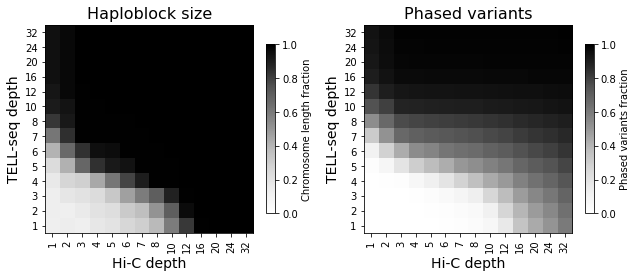

In [25]:
plt.figure(figsize = (9, 5))

plt.subplot(121)
plt.title('Haploblock size', fontsize = 16)
plt.imshow(np.average(haploblock_spans, axis = 0), vmin = 0, vmax = 1, cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('TELL-seq depth', fontsize = 14)
plt.colorbar(shrink = 0.5, label = 'Chromosome length fraction')

plt.subplot(122)
plt.title('Phased variants', fontsize = 16)
plt.imshow(np.average(phased_snps, axis = 0), vmin = 0, vmax = 1, cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('TELL-seq depth', fontsize = 14)
plt.colorbar(shrink = 0.5, label = 'Phased variants fraction')

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/simulations_tellseq_haploblock_variants.pdf', bbox_inches = 'tight')
plt.show()

/tmp/ipykernel_612916/3723275859.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.average(np.ma.masked_array(switch_errors, np.isnan(switch_errors)), axis = 0)).data,
/tmp/ipykernel_612916/3723275859.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.average(np.ma.masked_array(mismatch_errors, np.isnan(mismatch_errors)), axis = 0)).data,


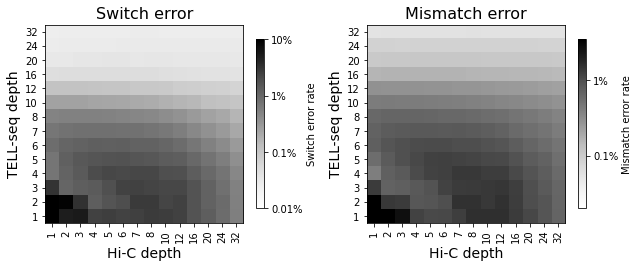

In [26]:
plt.figure(figsize = (9, 5))

plt.subplot(121)
plt.title('Switch error', fontsize = 16)
plt.imshow(np.log10(np.average(np.ma.masked_array(switch_errors, np.isnan(switch_errors)), axis = 0)).data, 
           vmax = np.log10(0.1), vmin = np.log10(0.0001), cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('TELL-seq depth', fontsize = 14)
cbar = plt.colorbar(shrink = 0.5, ticks = np.log10([0.1, 0.01, 0.001, 0.0001]), label = 'Switch error rate')
cbar.ax.set_yticklabels(['10%', '1%', '0.1%', '0.01%'])

plt.subplot(122)
plt.title('Mismatch error', fontsize = 16)
plt.imshow(np.log10(np.average(np.ma.masked_array(mismatch_errors, np.isnan(mismatch_errors)), axis = 0)).data, 
           vmax = np.log10(0.035), vmin = np.log10(0.0002), cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('TELL-seq depth', fontsize = 14)
cbar = plt.colorbar(shrink = 0.5, ticks = np.log10([0.01, 0.001]), label = 'Mismatch error rate')
cbar.ax.set_yticklabels(['1%', '0.1%'])

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/simulations_tellseq_switch_mismatch.pdf', bbox_inches = 'tight')
plt.show()

## stLFR reads simulations

In [27]:
haploblock_spans, phased_snps, switch_errors, mismatch_errors = [], [], [], []

for downsample_num in downsampling_reps:
    spans_tmp, snps_tmp, switches_tmp, mismatches_tmp = [], [], [], []
    for frac_lr in downsampling_depths:
        for frac_hic in downsampling_depths:
            
            # Extract information about MVP block and phased SNPs
            stats = get_haploblocks_parameters('stlfr', frac_hic, frac_lr, downsample_num)
            spans_tmp.append(stats['span_frac'].values[0])
            snps_tmp.append(stats['het_snp_phased_frac'].values[0])
            
            # Extract information about switch and mismatch errors
            errors = get_error_rates('stlfr', frac_hic, frac_lr, downsample_num)
            if errors[0] != 0 and errors[0] != 1:
                switches_tmp.append(errors[0])
            else:
                switches_tmp.append(np.nan)
            if errors[1] != 0 and errors[1] != 1:
                mismatches_tmp.append(errors[1])
            else:
                mismatches_tmp.append(np.nan)
                
    haploblock_spans.append(spans_tmp)
    phased_snps.append(snps_tmp)
    switch_errors.append(switches_tmp)
    mismatch_errors.append(mismatches_tmp)
    
haploblock_spans = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in haploblock_spans]
phased_snps = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in phased_snps]
switch_errors = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in switch_errors]
mismatch_errors = [np.array(x).reshape(len(downsampling_depths), len(downsampling_depths))[::-1] for x in mismatch_errors]

In [28]:
np.save('simulations_haploblock_spans_stLFR_HiC.npy', haploblock_spans)
np.save('simulations_phased_snps_stLFR_HiC.npy', phased_snps)
np.save('simulations_switch_errors_stLFR_HiC.npy', switch_errors)
np.save('simulations_mismatch_errors_stLFR_HiC.npy', mismatch_errors)

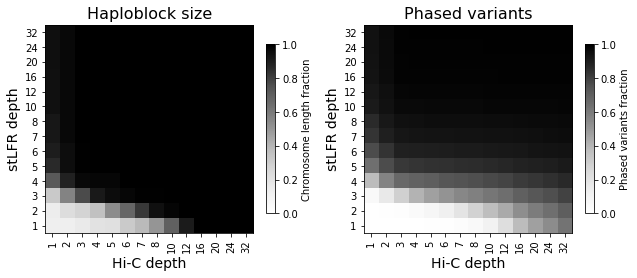

In [29]:
plt.figure(figsize = (9, 5))

plt.subplot(121)
plt.title('Haploblock size', fontsize = 16)
plt.imshow(np.average(haploblock_spans, axis = 0), vmin = 0, vmax = 1, cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('stLFR depth', fontsize = 14)
plt.colorbar(shrink = 0.5, label = 'Chromosome length fraction')

plt.subplot(122)
plt.title('Phased variants', fontsize = 16)
plt.imshow(np.average(phased_snps, axis = 0), vmin = 0, vmax = 1, cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('stLFR depth', fontsize = 14)
plt.colorbar(shrink = 0.5, label = 'Phased variants fraction')

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/simulations_stlfr_haploblock_variants.pdf', bbox_inches = 'tight')
plt.show()

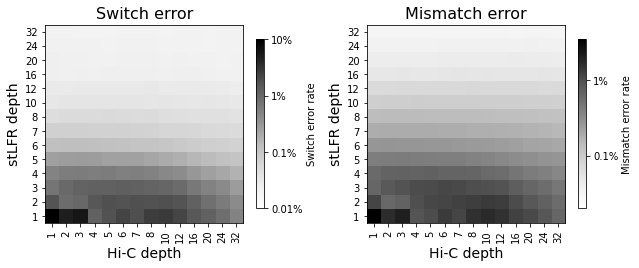

In [30]:
plt.figure(figsize = (9, 5))

plt.subplot(121)
plt.title('Switch error', fontsize = 16)
plt.imshow(np.log10(np.average(np.ma.masked_array(switch_errors, np.isnan(switch_errors)), axis = 0)).data, 
           vmax = np.log10(0.1), vmin = np.log10(0.0001), cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('stLFR depth', fontsize = 14)
cbar = plt.colorbar(shrink = 0.5, ticks = np.log10([0.1, 0.01, 0.001, 0.0001]), label = 'Switch error rate')
cbar.ax.set_yticklabels(['10%', '1%', '0.1%', '0.01%'])

plt.subplot(122)
plt.title('Mismatch error', fontsize = 16)
plt.imshow(np.log10(np.average(np.ma.masked_array(mismatch_errors, np.isnan(mismatch_errors)), axis = 0)).data, 
           vmax = np.log10(0.035), vmin = np.log10(0.0002), cmap = 'Greys')
plt.xticks(np.arange(len(downsampling_depths)), downsampling_depths, rotation = 90)
plt.yticks(np.arange(len(downsampling_depths)), downsampling_depths[::-1])
plt.xlabel('Hi-C depth', fontsize = 14)
plt.ylabel('stLFR depth', fontsize = 14)
cbar = plt.colorbar(shrink = 0.5, ticks = np.log10([0.01, 0.001]), label = 'Mismatch error rate')
cbar.ax.set_yticklabels(['1%', '0.1%'])

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/simulations_stlfr_switch_mismatch.pdf', bbox_inches = 'tight')
plt.show()